# Solution2：房價預測模型

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/taipeitechmmslab/MMSLAB-TF2/blob/master/Exercise/Solution2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/taipeitechmmslab/MMSLAB-TF2/blob/master/Exercise/Solution2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Import必要套件

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

### 數據讀取並分析

In [2]:
data = pd.read_csv("kc_house_data.csv")
# 顯示dataset的形狀，共21613比資料，每一比資料有21種不同資訊。
data.shape

(21613, 21)

In [3]:
# 將顯示列數設定為25，不然會有部份資料無法顯示
pd.options.display.max_columns = 25
# head 會顯示前五行的數據
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


各個數據的簡寫分別代表下面意思：
- date：房屋出售日期。
- price：房屋價格（目標）。
- bedrooms：臥室數量。
- bathrooms：浴室數量。
- sqft_living：居住的坪數（平方英尺）。
- sqft_lot：實際的坪數（平方英尺）。
- floors：房屋總共樓層。
- waterfront：海景房。
- view：房屋是否看過。
- condition：整體條件有多好。
- grade：房屋的整體等級（根據King County評分系統）。
- sqft_above：除了地下室外的坪數（平方英尺）。
- sqft_basement：地下室的坪數（平方英尺）。
- yr_built：房屋建造時間。
- yr_renovated：何時重新裝修過（一些沒重新裝修過或是裝修紀錄沒被記錄到的數值都為0）。
- zipcode：郵政編碼。
- lat：緯度座標。
- long：經度座標。
- sqft_living15：2015年紀錄的居住坪數（可能是翻新的原因導致sqft_living15與sqft_living不同）。
- sqft_lot15：2015年紀錄的實際坪數（可能是翻新的原因導致sqft_lot15與sqft_lot不同）。

### 檢查資料的型態

資料型態總共有五種：object(string),booleab, integer, float and categorical.

In [4]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### 數據前處理
轉換資料型態：
因為數據集裡的date數據是字串（string）格式，而模型的輸入只接受數值格式，所以可以透過以下程式碼將其轉為數值，並分成年、月及日三種數據。

In [5]:
# 將date日期拆為年、月和日並轉成數值
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))

# 刪除沒有用的數據，inplace則是將更新後的資料存回原本的地方
data.drop(['id'], axis="columns", inplace=True)
data.drop(['date'], axis="columns", inplace=True)

data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


分割數據集（Dataset）：將數據集切割成三個部份，訓練數據（Training data）、驗證數據（Validation data）和測試數據（Testing data）。

In [6]:
data_num = data.shape[0]
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation和test分為，這裡的劃分比例為6:2:2
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
# 透過索引值從data取出訓練資料、驗證資料和測試資料
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

### Normalization 正規化

使用標準分數(Standard Score, 又稱z-score)將數據正規化，經過z-score正規化後數據的都會聚集在0附近， 標準差為1。 

(x - 平均值) / 標準差

In [7]:
train_validation_data = pd.concat([train_data, val_data])
mean = train_validation_data.mean()
std = train_validation_data.std()

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std

### 建立Numpy array格式的訓練數據

In [8]:
x_train = np.array(train_data.drop('price', axis='columns'))
y_train = np.array(train_data['price'])
x_val = np.array(val_data.drop('price', axis='columns'))
y_val = np.array(val_data['price'])

整理過後的資料共12967筆，且一筆資料有21種資訊(所以網路輸入必須為21)。

In [9]:
x_train.shape

(12967, 21)

### 建立並訓練網路模型

這裡建構三層全連接層的網路架構，並且使用ReLU作為隱藏層的激活函數，而由於需得到線性輸出，故輸出層不使用任何激活函數。

提示: https://www.tensorflow.org/api_docs/python/tf/keras/layers?hl=zh-cn

In [10]:
# 建立一個Sequential型態的model
model = keras.Sequential(name='model-1')
# 第1層全連接層設為128個unit，kernel_regularizer=l1，將輸入形狀設定為(21, )
model.add(layers.Dense(128, 
                       kernel_regularizer=keras.regularizers.l1(0.001), 
                       input_shape=(21,)))
# 第3層激活層(activation layer)為LeakyReLU
model.add(layers.LeakyReLU())
# 第4層Dropout層，捨棄比率設定為20%
model.add(layers.Dropout(0.2))
# 第5層全連接層設為128個unit，kernel_regularizer=l1
model.add(layers.Dense(128, 
                       kernel_regularizer=keras.regularizers.l1(0.001)))
# 第6層激活層(activation layer)為LeakyReLU
model.add(layers.LeakyReLU())
# 第7層Dropout層，捨棄比率設定為20%
model.add(layers.Dropout(0.2))
# 最後一層全連接層設為1個unit
model.add(layers.Dense(1))
# 顯示網路模型架構
model.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2816      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129 

設定訓練使用的優化器、損失函數和指標函數：

In [11]:
model.compile(
    # optimizers使用Adam(0.002)
    optimizer=keras.optimizers.Adam(0.002),
    # loss使用MAE Loss
    loss=keras.losses.MeanSquaredError()
)

創建模型儲存目錄：

In [12]:
model_dir = 'lab2-logs/models/'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

設定回調函數：

In [13]:
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
log_dir = os.path.join('lab2-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                        monitor='val_mean_absolute_error', 
                                        save_best_only=True, 
                                        mode='min')

訓練網路模型：

In [14]:
history = model.fit(x_train, y_train,  # 傳入訓練數據
               batch_size=64,  # 批次大小設為64
               epochs=100,  # 整個dataset訓練50遍
               validation_data=(x_val, y_val),  # 驗證數據
               callbacks=[model_cbk, model_mckp])  # Tensorboard回調函數紀錄訓練過程，ModelCheckpoint回調函數儲存最好的模型

Epoch 1/100
203/203 [==============================] - 1s 4ms/step - loss: 1.4956 - val_loss: 1.0154
Epoch 2/100
203/203 [==============================] - 0s 2ms/step - loss: 0.8638 - val_loss: 0.6618
Epoch 3/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5800 - val_loss: 0.4798
Epoch 4/100
203/203 [==============================] - 0s 2ms/step - loss: 0.4496 - val_loss: 0.4532
Epoch 5/100
203/203 [==============================] - 0s 2ms/step - loss: 0.3969 - val_loss: 0.3158
Epoch 6/100
203/203 [==============================] - 0s 2ms/step - loss: 0.3552 - val_loss: 0.2896
Epoch 7/100
203/203 [==============================] - 0s 2ms/step - loss: 0.3245 - val_loss: 0.2905
Epoch 8/100
203/203 [==============================] - 0s 2ms/step - loss: 0.3248 - val_loss: 0.2680
Epoch 9/100
203/203 [==============================] - 0s 2ms/step - loss: 0.3031 - val_loss: 0.2861
Epoch 10/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2918 - val_lo

203/203 [==============================] - 0s 2ms/step - loss: 0.3046 - val_loss: 0.2472
Epoch 33/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2890 - val_loss: 0.2398
Epoch 34/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2694 - val_loss: 0.2248
Epoch 35/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2771 - val_loss: 0.2191
Epoch 36/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2635 - val_loss: 0.2211
Epoch 37/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2514 - val_loss: 0.2290
Epoch 38/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2700 - val_loss: 0.2540
Epoch 39/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2648 - val_loss: 0.2160
Epoch 40/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2579 - val_loss: 0.2246
Epoch 41/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2576 - val_loss: 

203/203 [==============================] - 0s 2ms/step - loss: 0.2624 - val_loss: 0.2326
Epoch 65/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2640 - val_loss: 0.2313
Epoch 66/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2590 - val_loss: 0.2167
Epoch 67/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2619 - val_loss: 0.2281
Epoch 68/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2612 - val_loss: 0.2200
Epoch 69/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2503 - val_loss: 0.2253
Epoch 70/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2793 - val_loss: 0.2216
Epoch 71/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2690 - val_loss: 0.2294
Epoch 72/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2707 - val_loss: 0.2139
Epoch 73/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2582 - val_loss: 

203/203 [==============================] - 0s 2ms/step - loss: 0.2595 - val_loss: 0.2048
Epoch 96/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2440 - val_loss: 0.2162
Epoch 97/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2580 - val_loss: 0.2220
Epoch 98/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2634 - val_loss: 0.2222
Epoch 99/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2482 - val_loss: 0.2071
Epoch 100/100
203/203 [==============================] - 0s 2ms/step - loss: 0.2773 - val_loss: 0.2232


### 訓練結果

In [15]:
history.history.keys()  # 查看history儲存的資訊有哪些

dict_keys(['loss', 'val_loss'])

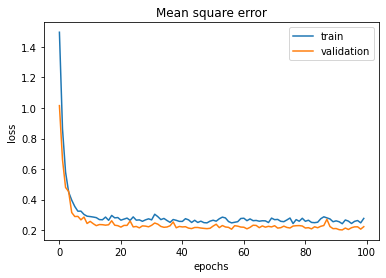

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

測試數據的誤差百分比：用測試數據預測房屋價格並與答案計算誤差百分比。

In [17]:
# 載入模型
model = keras.models.load_model('lab2-logs/models/Best-model-1.h5')
# 先將房屋價格取出
y_test = np.array(test_data['price'])
# 標準化數據
test_data = (test_data - mean) / std
# 將輸入數據存成Numpy 格式
x_test = np.array(test_data.drop('price', axis='columns'))
# 預測測試數據
y_pred = model.predict(x_test)
# 將預測結果轉換回來(因為訓練時的訓練目標也有經過標準化)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model Percentage Error: {:.2f}%".format(percentage_error))

Model Percentage Error: 15.74%
